# Bookkeeping

In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy.stats import norm, lognorm
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from sedgen.input import Input
from sedgen import weathering

In [3]:
# Load jupyter extension to reload packages before executing user code.
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
# Reload all packages (except those excluded by %aimport) every time before executing the Python code typed.
%autoreload 2

In [4]:
tester = np.zeros((6, 2000), dtype='int32')

In [5]:
tester[0].shape

(2000,)

In [7]:
tester[0]

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
bins = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
bins = bins.astype('str')

In [22]:
counts = np.array([0, 1, 2, 0, 4, 5, 6, 8, 0, 0])

In [35]:
dict_ = {}

for bin_, count in zip(bins, counts):
    if count == 0:
        continue
    else:
        dict_[bin_] = count

In [39]:
dict_

{'1': 1, '2': 2, '4': 4, '5': 5, '6': 6, '7': 8}

In [36]:
from sys import getsizeof

In [68]:
{np.array(bins[:-1]), tester[0]}

TypeError: unhashable type: 'numpy.ndarray'

In [53]:
tester.nbytes / 1024 / 1024

0.0457763671875

The input of data needs to be split up into two parts:
- 1. Firstly, the part of data that comes from the dataset entered into the model, this needs to be boiled down to the fundamental properties (modal mineralogy, intefacial data, and crystal size data) + properties of the environment
- 2. Secondly, for all of the parameters for which no corresponding data was entered, a substiutute needs to be constructed. For the fundamental properties this can fall back on the relations discovered during the PhD (e.g. lognormal CSD). The environmental properties might be selected by the user, nonetheless.

## 1. Modal mineralogy

In [44]:
# Minerals present
minerals = ["Q" ,"P", "K", "B", "O", "A"]

In [45]:
modal_mineralogy = np.array([0.3, 0.35, 0.15, 0.10, 0.02, 0.08])

In [46]:
prng = np.random.RandomState(1234)

In [47]:
test = prng.choice(np.array([0, 1, 2, 3, 4, 5]), size=20000, replace=True, p=modal_mineralogy)

In [48]:
_, counts = np.unique(test, return_counts=True)

In [49]:
counts

array([6005, 6943, 3067, 1940,  384, 1661], dtype=int64)

## 2. CSD

In [50]:
# You can pass in the arithmetic standard deviation as s (= the shape)
# You can pass in the exponent of the arithmetic mean as the scale
# You can pass in the geometric mean as the scale

In [51]:
csds = np.array([
    lognorm(s=1, loc=0, scale=1),
    lognorm(s=1, loc=0, scale=1),
    lognorm(s=1, loc=0, scale=1),
    lognorm(s=1, loc=0, scale=1),
    lognorm(s=1, loc=0, scale=1),
    lognorm(s=1, loc=0, scale=1),
])

In [52]:
np.exp(csds[0].median())

2.718281828459045

In [57]:
n_crystals = 1e9 / calculate_volume_sphere(np.exp(csds[0].median()), diameter=True)
n_crystals/1e6

95.08629639359629

In [58]:
%%time
csd_sample = csds[0].rvs(int(n_crystals))
crystal_counts_binned_test, _ = np.histogram(np.exp(csd_sample), bins=bins)

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

In [59]:
csd_sample.nbytes / 1024 / 1024  # MB

725.4508666992188

In [60]:
%%time
test = (csds[0].pdf(bins)*int(n_crystals)).astype('int')

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U11')) -> dtype('<U11')

In [61]:
pdf_normalized = csds[0].pdf(bins) / np.sum(csds[0].pdf(bins))

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U11'), dtype('<U11')) -> dtype('<U11')

In [ ]:
test = (pdf_normalized * n_crystals).astype('int')

In [ ]:
bins_medians = [1.5 * 2.0**x for x in np.arange(-10, 10.01, 0.01)]

In [41]:
test.dtype

dtype('int32')

In [43]:
2**32 / 1e9

4.294967296

In [40]:
6 * test.nbytes / 1024  # kB

46.8984375

In [194]:
test.sum()

95085508

In [195]:
bins_volumes = calculate_volume_sphere(np.array(bins_medians), diameter=True)

In [196]:
np.sum(test * bins_volumes) / 1e9

0.7296020964387707

<BarContainer object of 2001 artists>

(0.000244140625, 1024)

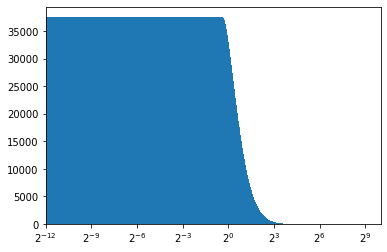

In [117]:
plt.bar(bins, test)
plt.gca().set_xscale('log', basex=2)
plt.xlim(2**-12, 2**10)

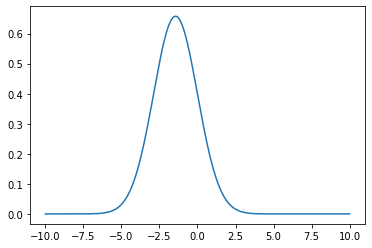

In [70]:
plt.plot(np.log2(bins), csds[0].pdf(bins))

In [27]:
np.exp(csds[0].mean())

5.2003257647899614

In [62]:
%%time
# Obtain crystal sizes per mineral class
crystal_sizes = []
for csd, crystals in zip(csds, counts):
#     print(csd, crystals)
    crystal_sizes.append(csd.rvs(size=crystals, random_state=1234))

Wall time: 1.97 ms


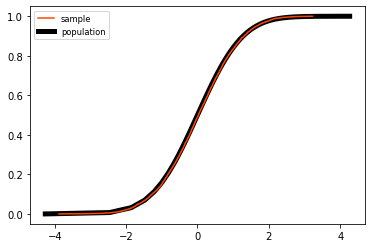

In [17]:
plt.plot(np.log(ecdf(crystal_sizes[0])[0]), ecdf(crystal_sizes[0])[1], 
         color='orangered', zorder=10, label="sample")

x = np.linspace(csds[0].ppf(0.00001), csds[0].ppf(0.99999), 1000)
plt.plot(np.log(x), csds[0].cdf(x), 
         color='k', lw=5, label="population")

plt.legend(fontsize='small')
plt.show();

In [66]:
# Bins according to phi scale in quarters (in mm)
# To Do: Make lower- and upper bin boundaries model parameters (and attributes)
bins = [2.0**x for x in np.arange(-10, 10.01, 0.01)]

In [67]:
crystal_counts_binned = np.zeros((6, 2000))
for i in range(6):
    crystal_counts_binned[i], _ = np.histogram(crystal_sizes[i], bins=bins)

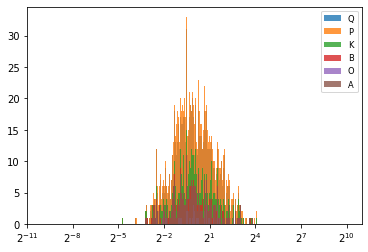

In [20]:
for i in range(6):
    plt.hist(crystal_sizes[i], bins=bins, label=minerals[i], alpha=0.8)
plt.gca().set_xscale('log', basex=2)
plt.legend(fontsize='small')
plt.show();

In [63]:
crystal_sizes_sum_total = 0
for i in range(6):
    print(minerals[i], crystal_sizes[i].sum())
    crystal_sizes_sum_total += crystal_sizes[i].sum()

Q 9918.392700030865
P 11450.004600725795
K 5140.702784406363
B 3245.63696652118
O 651.1386442209653
A 2789.404561612471


In [21]:
crystal_sizes_sum_total

33195.28025751764

In [9]:
def calculate_volume_sphere(r, diameter=False):
    if diameter:
        r = r/2
    
    volume = 4/3 * r**3 * np.pi
    return volume

In [10]:
def calculate_equivalent_circular_diameter(volume):
    diameter = 2 * (3/4 * volume / np.pi) ** (1/3)
    
    return diameter

In [24]:
crystal_sizes_volume_total = 0
for i in range(6):
    volumes = calculate_volume_sphere(crystal_sizes[i], diameter=True)
    print(minerals[i], volumes.sum())
    crystal_sizes_volume_total += volumes.sum()

Q 156190.83190647393
P 180345.1925750545
K 89892.80872030772
B 57613.65136188341
O 10024.37333383742
A 52009.45666716363


In [25]:
crystal_sizes_volume_total  # in mm³
crystal_sizes_volume_total / 1e9 # in m³

546076.3145647206

0.0005460763145647206

In [106]:
from sklearn.model_selection import train_test_split

In [112]:
train_test_split(np.random.randint(0, 3, (20)), train_size=0.7, random_state=1234)

[array([0, 2, 2, 2, 0, 0, 1, 0, 2, 2, 1, 0, 0, 1]), array([0, 1, 1, 1, 2, 0])]

In [54]:
def split_size(n):
    if n > 10:
        split_size = (0.9-0.1) * prng.random_sample() + 0.1
    else:
        a = 1/n
        b = 1 - a
        split_size = (b-a) * prng.random_sample() + a
    return split_size

In [116]:
%%timeit
np.random.random(2)

1.27 µs ± 20.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [7]:
def mechanical_weathering(steps):
    composition_new = [1]
    single_crystals = 0
    threshold = 1e-8

    for i in range(steps):
    #     print(composition_new)
        composition_old = composition_new
        composition_new = []

        for comp in composition_old:
            a, b = np.random.random(2)
    #         print(a, b)
            # Normalize and b
            sum_ = a + b
            a, b = a/sum_, b/sum_

            # Move fractions smaller than threshold to single crystals count
            for split in [a, b]:
                if split * comp <= threshold:
                    single_crystals += 1
                else:
                    composition_new += [split * comp]
    #         composition_new += [a*comp, b*comp] 

In [8]:
%%time
mechanical_weathering(20)

Wall time: 3.2 s


In [105]:
a = np.array([[1, 2],
              [3, 4],
              [5, 6]])

b = np.array([[3],
              [2],
              [1]])

In [108]:
b.reshape((1, -1))

array([[3, 2, 1]])

In [146]:
a * b

array([[3, 6],
       [6, 8],
       [5, 6]])

In [152]:
(a * np.array([1, 2, 3]).reshape(-1, 1)).flatten()

array([ 1,  2,  6,  8, 15, 18])

In [70]:
100e6 * 1e-8

1.0

In [13]:
def mechanical_weathering_vectorized(steps, verbose=False, threshold=1e-8):
    """Threshold value is based on number of crystals that is expected to be 
    present in one cubic meter of parent rock which in turn is based on the average bulk crystal size
    
    Example:
    --------
    200 million crystals in 1 m³ means that a proportion of 0.5e-8 presents one crystal.
    When a proprtion is less than or equal to this threshold this would thus mean that 
    the pcg is no longer a pcg but has become a mcg.
    """
    composition_new = np.array([1])
    pcg_evolution = np.zeros(steps)
    mcg_evolution = np.zeros(steps)
    pcg_memory_usage = np.zeros(steps)
    single_crystals = 0

    for i in range(steps):
        composition_old = composition_new
        if verbose:
            print("composition_old", composition_old)
            print("composition_old_shape", composition_old.shape)
            
        # Obtain random fractions
        ab = np.random.random((2, composition_old.shape[0]))
        ab_norm = np.divide(ab, np.sum(ab, axis=0))
        if verbose:
            print("ab", ab)
            print("ab_norm", ab_norm)

        # Create new composition from old one and fractions
        composition_new = np.multiply(ab_norm.T, composition_old.reshape(-1, 1)).flatten()
        if verbose:
            print("composition_new", composition_new)
            print("composition_new_sum", np.sum(composition_new), "\n")
            
        # Move fractions smaller than threshold to single crystals count
        condition = composition_new <= threshold
        single_crystals += np.sum(condition)
        if verbose:
            print("single_crystals", single_crystals)
        composition_new = composition_new[~condition]
        
        if verbose:
            print("composition_new", composition_new)
            print("composition_new_sum", np.sum(composition_new), "\n")
        
        # Keep track of evolution of pcg and mcg
        pcg_evolution[i] = composition_new.shape[0]
        mcg_evolution[i] = single_crystals
        pcg_memory_usage[i] = composition_new.nbytes / 1024**2
        if composition_new.shape[0] == 0:
            print(i)
            break
        
    return composition_new, single_crystals, pcg_evolution, mcg_evolution, pcg_memory_usage

In [17]:
%%time
tester = mechanical_weathering_vectorized(60, verbose=False, threshold=1e-5)

35
Wall time: 13 ms


In [18]:
print("pcg:", tester[0].shape[0], "\nmcg:", tester[1])

pcg: 0 
mcg: 177566


In [6]:
print("pcg:", tester[0].shape[0], "\nmcg:", tester[1])

pcg: 0 
mcg: 17735461


In [58]:
15 * 0.5

7.5

In [92]:
test = np.sort(np.array([[0.99, 0.01], [0.5, 0.5]]) * np.array([[15], [30]]))
test

array([[ 0.15, 14.85],
       [15.  , 15.  ]])

In [93]:
np.ceil(test[:, 0])

array([ 1., 15.])

In [94]:
np.floor(test[:, 1])

array([14., 15.])

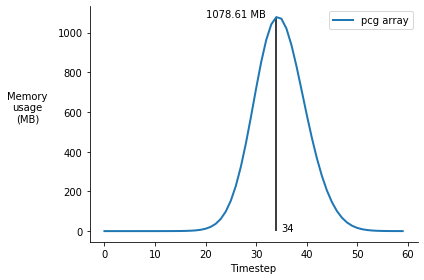

In [7]:
# Threshold set at 1e-9

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

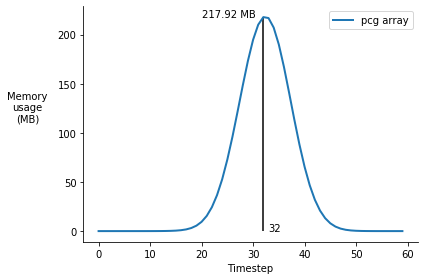

In [111]:
# Threshold set at 1e-8

# Memory usage of pcg array across timesteps
plt.plot(tester[4], lw=2, label='pcg array')
x_max = np.where(tester[4] == tester[4].max())[0][0]
y_max = tester[4].max()
# print(x_max, y_max)

# Annotate maximum memory usage
plt.annotate(f"{y_max:3.2f} MB", 
             (x_max, y_max),
             (20, y_max))
# Annotate timestep where maximum memory usage is reached
plt.annotate(x_max, 
             (x_max, 0),
             (x_max+1, 0))

plt.vlines(np.where(tester[4] == tester[4].max()), 0, tester[4].max())
plt.xlabel("Timestep")
plt.ylabel("Memory\nusage\n(MB)", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

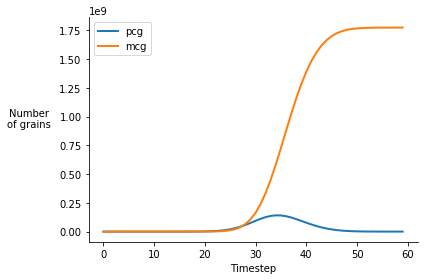

In [8]:
# Threshold set at 1e-9

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

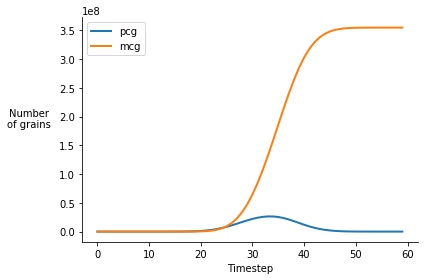

In [85]:
# Threshold set at 1e-8

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

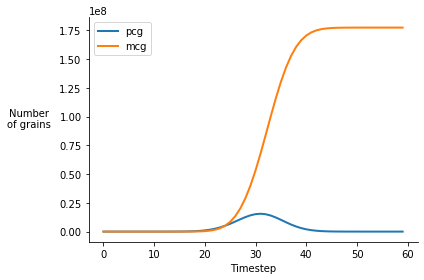

In [82]:
# Threshold set at 2e-8

# Evoluton of number of pcg and mcg through timesteps
plt.plot(tester[2], lw=2, label="pcg")
plt.plot(tester[3], lw=2, label="mcg")
plt.xlabel("Timestep")
plt.ylabel("Number\nof grains", rotation=0, labelpad=30)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show();

In [50]:
tester[0].nbytes / 1024**2

0.0599822998046875

In [23]:
%lprun -f mechanical_weathering_vectorized mechanical_weathering_vectorized(50)

Timer unit: 1e-07 s

Total time: 14.5192 s
File: <ipython-input-13-cddeb2998bb1>
Function: mechanical_weathering_vectorized at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mechanical_weathering_vectorized(steps, verbose=False, threshold=1e-8):
     2                                               """Threshold value is based on number of crystals that is expected to be 
     3                                               present in one cubic meter of parent rock which in turn is based on the average bulk crystal size
     4                                               
     5                                               Example:
     6                                               --------
     7                                               200 million crystals in 1 m³ means that a proportion of 0.5e-8 presents one crystal.
     8                                               When a proprtion is less than 

In [23]:
1e6 * np.random.randint(0, high=5, size=(6, 200)).nbytes / 1024**3

4.470348358154297

In [11]:
calculate_equivalent_circular_diameter(1e9)

1240.7009817987996

In [39]:
2**25 / 1e6

33.554432

In [35]:
len(composition_new)

6309120

In [36]:
single_crystals

5995115

In [58]:
test_list = []

In [59]:
test_list += []
test_list

[]

In [37]:
len(composition_new)

1048576

In [41]:
composition_new_array = np.array(composition_new)

In [49]:
2e8 / 1e8

2.0

In [51]:
2e8 * 1e-8

2.0

In [52]:
np.sum(composition_new_array < 1e-8)

406164

In [40]:
np.min(ncomposition_new)

2.6814633045115137e-17

In [32]:
from sys import getsizeof

In [37]:
print(getsizeof(composition_new) / (1024**2), "MB")

48.53956604003906 MB


In [23]:
split_size(4)

NameError: name 'split_size' is not defined

In [141]:
# %%timeit
x1, x2 = train_test_split(crystal_sizes[0], train_size=(0.9-0.1) * prng.random_sample() + 0.1, random_state=1234)

In [240]:
test = np.arange(10000, dtype='int16')
test

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int16)

In [231]:
test.dtype

dtype('int16')

In [248]:
labels = np.array([0]*5000 + [1]*5000, dtype='bool')

In [269]:
# Bins according to phi scale in quarters (in mm)
bins = [2.0**x for x in np.arange(-10, 10.1, 0.1)]

In [274]:
np.array(bins).nbytes *1e6 / (1024**3)

1.4975666999816895

In [278]:
np.random.randint(low=0, high=10000, size=200, dtype='uint16').nbytes

400

In [41]:
from scipy import sparse

In [42]:
from sys import getsizeof

In [102]:
tester = np.random.randint(0, 1, (10, 6, 2000), dtype='int32')

In [103]:
getsizeof(tester)

480128

In [104]:
tester.nbytes

480000

In [105]:
tester_sparse = sparse.dok_matrix(tester)

TypeError: Expected rank <=2 dense array or matrix.

In [100]:
getsizeof(tester_sparse)

295024

In [83]:
tester

dict_values([])

In [80]:
getsizeof(crystal_counts_binned[0])

96

In [81]:
crystal_counts_binned[0].nbytes

16000

In [70]:
crystal_counts_binned[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [71]:
np.array(bins)

array([9.76562500e-04, 9.83355029e-04, 9.90194804e-04, ...,
       1.00990229e+03, 1.01692672e+03, 1.02400000e+03])

**Sparse matrices would become interesting if the non-zero values to be stored are floats and not integers.**  
**By using appropriate datatypes, memory usage can be reduced**  

In [314]:
sparse_array = sparse.coo_matrix(crystal_counts_binned[0])
sparse_array.data.nbytes, sparse_array.row.nbytes, sparse_array.col.nbytes

(190, 380, 380)

In [330]:
sparse_array = sparse.csr_matrix(crystal_counts_binned[0])
sparse_array.data
sparse_array.dtype
sparse_array.indptr
sparse_array.indices
sparse_array.data.nbytes, sparse_array.indptr.nbytes, sparse_array.indices.nbytes
sparse_array.data.nbytes + sparse_array.indptr.nbytes + sparse_array.indices.nbytes

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,  1.,  1.,  1.,  1.,
        2.,  1.,  1.,  1.,  3.,  2.,  3.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  1.,  1.,  2.,  1.,  2.,  2.,  1.,  3.,  1.,  5.,  2.,
        3.,  2.,  2.,  3.,  1.,  3.,  3.,  2.,  1.,  2.,  4.,  4.,  2.,
        2.,  1.,  1.,  1.,  3.,  3.,  3.,  4.,  2.,  3.,  3.,  3.,  1.,
        1.,  2.,  3.,  2.,  1.,  1.,  2.,  2.,  3.,  2.,  6.,  3.,  1.,
        5.,  5.,  3.,  2.,  4.,  3.,  2.,  2., 10.,  4.,  2.,  3.,  4.,
        5.,  2.,  3.,  3.,  5.,  2.,  7.,  7.,  3., 12.,  7.,  5.,  3.,
        6.,  4.,  5.,  3.,  3.,  1.,  3.,  3.,  1.,  2.,  4.,  3.,  4.,
        6.,  5.,  3.,  6.,  2.,  5.,  7.,  3.,  4.,  7.,  2.,  3.,  6.,
        5.,  9.,  5.,  3.,  6.,  5.,  4.,  4.,  5.,  5.,  2., 11.,  3.,
        8.,  4.,  7.,  6.,  7.,  7.,  3., 10.,  9.,  5.,  5.,  9.,  7.,
        8.,  9.,  7.,  9.,  6.,  9.,  7.,  6.,  2.,  6.,  5.,  7

dtype('float64')

array([  0, 725], dtype=int32)

array([ 440,  480,  485,  504,  527,  529,  533,  545,  564,  568,  569,
        575,  602,  613,  614,  615,  616,  621,  623,  624,  625,  627,
        628,  629,  630,  631,  634,  643,  645,  647,  650,  653,  654,
        656,  657,  658,  660,  663,  666,  667,  671,  673,  674,  675,
        676,  678,  679,  680,  681,  682,  683,  684,  685,  687,  689,
        690,  692,  693,  694,  695,  696,  697,  699,  700,  701,  702,
        703,  704,  705,  706,  707,  708,  710,  711,  712,  713,  714,
        715,  716,  717,  718,  719,  720,  721,  722,  723,  724,  725,
        726,  727,  728,  729,  730,  731,  732,  733,  734,  735,  736,
        737,  738,  739,  740,  741,  742,  743,  744,  745,  746,  747,
        748,  749,  750,  751,  752,  753,  754,  755,  756,  757,  758,
        759,  760,  761,  762,  763,  764,  765,  766,  767,  768,  769,
        770,  771,  772,  773,  774,  775,  776,  777,  778,  779,  780,
        781,  782,  783,  784,  785,  786,  787,  7

(5800, 8, 2900)

8708

In [ ]:
sparse.random()

In [209]:
# %%timeit
testA1, testA2, labelsA1, labelsA2 = train_test_split(test, labels, train_size=split_size(test.size))

In [183]:
testB1, testB2 = train_test_split(test, 
                                train_size=split_size(test.size))

In [249]:
test.nbytes
labels.nbytes

20000

10000

In [226]:
1.3e8 / (1024*1024*1024)

0.12107193470001221

In [210]:
testA1
labelsA1
testA2
labelsA2

array([1270,  555, 6171, ..., 6679, 3488, 4346])

array([0, 0, 1, ..., 1, 0, 0])

array([ 787, 3362, 8373, ..., 6974, 7276, 8735])

array([0, 0, 1, ..., 1, 1, 1])

In [160]:
train_test_split(test1, train_size=split_size(test1.size))
train_test_split(test2, train_size=split_size(test2.size))

[array([4]), array([7])]

[array([6, 3, 1]), array([9, 0, 5, 2, 8])]

In [91]:
crystal_sizes

AttributeError: 'numpy.ndarray' object has no attribute 'szie'

In [84]:
crystal_sizes[0].shape

(6005,)

In [85]:
x1.shape, x2.shape

((711,), (5294,))

In [36]:
crystal_sizes[0]

array([1.6022921 , 0.30392458, 4.19002612, ..., 0.34813099, 0.38173981,
       3.76740571])

In [26]:
calculate_equivalent_circular_diameter(crystal_sizes_volume_total)

101.41096278205382

In [34]:
crystal_counts_binned

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   4.,
          3.,   2.,   8.,  14.,  20.,  45.,  53.,  95., 106., 131., 170.,
        193., 282., 300., 325., 385., 387., 416., 399., 417., 385., 355.,
        312., 255., 242., 184., 147., 115.,  78.,  69.,  49.,  19.,  15.,
         11.,   6.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   4.,
          3.,   4.,  11.,  15.,  23.,  47.,  56., 106., 119., 156., 191.,
        222., 324., 351., 395., 440., 461., 485., 458., 492., 443., 404.,
        357., 293., 278., 212., 164., 134.,  89.,  82.,  56.,  23.,  16.,
         13.,   8.,   2.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0

___

## Lognormal distribution tests

In [11]:
from scipy.stats import gmean

In [16]:
gmean(np.random.normal(5, 1, 10000))

4.9018317882522195

In [19]:
np.exp(np.mean(np.log(np.random.normal(5, 1, 10000))))

4.903473709354666

In [ ]:
np.mean(np.random.normal(5, 1, 10000))

In [14]:
np.mean(np.random.lognormal(0, 1, 10000))

1.676016677534841

In [134]:
tester1 = lognorm(1, 0, 16)
tester2 = lognorm(1, 0, 1)

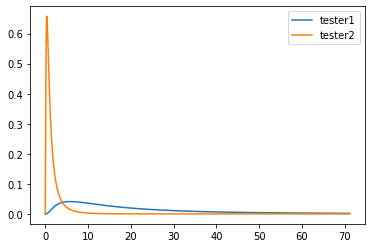

In [135]:
plt.plot(x, tester1.pdf(x), label="tester1")
plt.plot(x, tester2.pdf(x), label="tester2")
plt.legend()
plt.show();

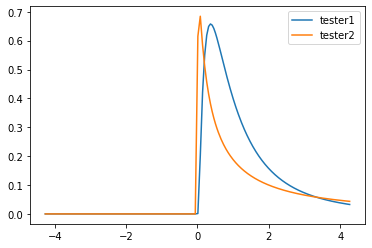

In [129]:
plt.plot(np.log(x), tester1.pdf(np.log(x)), label="tester1")
plt.plot(np.log(x), tester2.pdf(np.log(x)), label="tester2")
plt.legend()
plt.show();

In [80]:
mu = 0
sigma = 1

norm_test = norm(loc=3.54, scale=1.5)
# s = shape = sigma = std of underlying normal distribution
# loc = Z0 in Y = s * (Z - Z0) ** scale --> set loc=0 for standard lognormal behaviour
# scale = exp(mu) where mu = mean of underlying normal distribution = median of lognormal distribution
lognorm_test = lognorm(s=sigma, loc=0, scale=np.exp(mu))
# np.exp(mu) = geometric mean of underlying normal distribution N~(0, 1) or median of lognormal distribution

In [87]:
x = np.linspace(-4, 4, 1000)

In [88]:
norm_sample = np.random.normal(0, 1, 10000)

In [89]:
lognorm_sample = np.random.lognormal(0, 1, 10000)

In [8]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements.

    Parameters:
    -----------
    n : int
        Number of data points
    x : list/array
        x-data for the ECDF
    y : list/array
        y-data for the ECDF

    Returns:
    --------
    x : list/array
        Data
    y : list/array
        cdf
    """

    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / float(n)

    return x, y

In [85]:
lognorm_sample_cdf = ecdf(np.log(lognorm_sample))

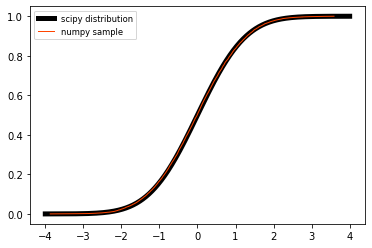

In [90]:
plt.plot(x, lognorm_test.cdf(np.exp(x)), c='k', lw=5, label="scipy distribution")
plt.plot(lognorm_sample_cdf[0], lognorm_sample_cdf[1], color='orangered', lw=1, label="numpy sample")
# plt.plot(x, norm_test.pdf(x), c="orangered")
plt.legend(fontsize='small')
plt.show();

In [14]:
np.exp(mu)

1.0

In [13]:
lognorm_test.stats()

(array(1.64872127), array(4.67077427))

In [465]:
# Formula for mean of lognormal distribution based on underlying normal distribution's mean and std
np.exp(mu + (sigma**2)/2)

1.6487212707001282

In [463]:
# Formula for variance of lognormal distribution based on underlying normal distribution's mean and std
(np.exp(sigma**2) - 1) * np.exp(2*mu+sigma**2)

4.670774270471604

In [17]:
np.sqrt(4.67)

2.1610182784974308

In [480]:
lognorm_test.stats()[0] * np.sqrt(lognorm_test.stats()[1])

3.5632121497683826

In [249]:
def prepare_lognorm(mean, var):
    # Formula from https://en.wikipedia.org/wiki/Log-normal_distribution
    sigma = np.sqrt(np.log(1 + (float(var) / mean ** 2)))
    mu = np.log(mean / np.sqrt(1 + (float(var) / mean ** 2)))
    # Compute the scale for scipy
    # For more details, check: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
    return lognorm(sigma, scale=np.exp(mu))
 

MEAN = 0.0001
VAR = 1 ** 2
cmp_mean, cmp_var = prepare_lognorm(MEAN, VAR).stats(moments='mv')
np.testing.assert_array_almost_equal([cmp_mean, cmp_var], [MEAN, VAR])

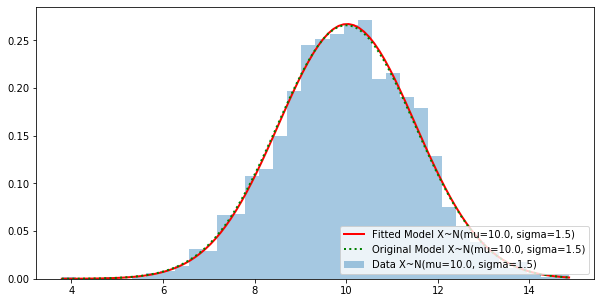

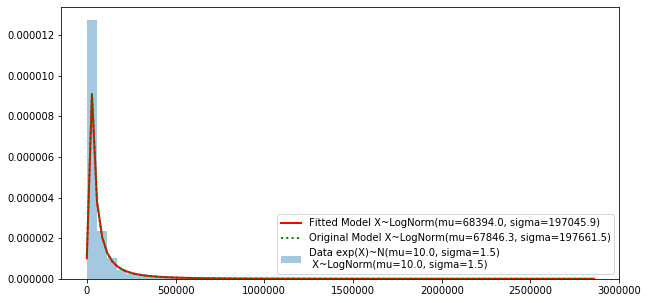

In [331]:
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

mu = 10 # Mean of sample !!! Make sure your data is positive for the lognormal example 
sigma = 1.5 # Standard deviation of sample
N = 2000 # Number of samples

norm_dist = scipy.stats.norm(loc=mu, scale=sigma) # Create Random Process
x = norm_dist.rvs(size=N) # Generate samples

# Fit normal
fitting_params = scipy.stats.norm.fit(x)
norm_dist_fitted = scipy.stats.norm(*fitting_params)
t = np.linspace(np.min(x), np.max(x), 100)

# Plot normals
f, ax = plt.subplots(1, sharex='col', figsize=(10, 5))
sns.distplot(x, ax=ax, norm_hist=True, kde=False, label='Data X~N(mu={0:.1f}, sigma={1:.1f})'.format(mu, sigma))
ax.plot(t, norm_dist_fitted.pdf(t), lw=2, color='r',
        label='Fitted Model X~N(mu={0:.1f}, sigma={1:.1f})'.format(norm_dist_fitted.mean(), norm_dist_fitted.std()))
ax.plot(t, norm_dist.pdf(t), lw=2, color='g', ls=':',
        label='Original Model X~N(mu={0:.1f}, sigma={1:.1f})'.format(norm_dist.mean(), norm_dist.std()))
ax.legend(loc='lower right')
plt.show()


# The lognormal model fits to a variable whose log is normal
# We create our variable whose log is normal 'exponenciating' the previous variable

x_exp = np.exp(x)
mu_exp = np.exp(mu)
sigma_exp = np.exp(sigma)

fitting_params_lognormal = scipy.stats.lognorm.fit(x_exp, floc=0, scale=mu_exp)
lognorm_dist_fitted = scipy.stats.lognorm(*fitting_params_lognormal)
t = np.linspace(np.min(x_exp), np.max(x_exp), 100)

# Here is the magic I was looking for a long long time
lognorm_dist = scipy.stats.lognorm(s=sigma, loc=0, scale=np.exp(mu))

# The trick is to understand these two things:
# 1. If the EXP of a variable is NORMAL with MU and STD -> EXP(X) ~ scipy.stats.lognorm(s=sigma, loc=0, scale=np.exp(mu))
# 2. If your variable (x) HAS THE FORM of a LOGNORMAL, the model will be scipy.stats.lognorm(s=sigmaX, loc=0, scale=muX)
# with:
#    - muX = np.mean(np.log(x))
#    - sigmaX = np.std(np.log(x))


# Plot lognormals
f, ax = plt.subplots(1, sharex='col', figsize=(10, 5))
sns.distplot(x_exp, ax=ax, norm_hist=True, kde=False,
             label='Data exp(X)~N(mu={0:.1f}, sigma={1:.1f})\n X~LogNorm(mu={0:.1f}, sigma={1:.1f})'.format(mu, sigma))
ax.plot(t, lognorm_dist_fitted.pdf(t), lw=2, color='r',
        label='Fitted Model X~LogNorm(mu={0:.1f}, sigma={1:.1f})'.format(lognorm_dist_fitted.mean(), lognorm_dist_fitted.std()))
ax.plot(t, lognorm_dist.pdf(t), lw=2, color='g', ls=':',
        label='Original Model X~LogNorm(mu={0:.1f}, sigma={1:.1f})'.format(lognorm_dist.mean(), lognorm_dist.std()))
ax.legend(loc='lower right')
plt.show()

___

___

## Random dataset generation

In [105]:
# Minerals present
minerals = ["Q" ,"P", "K", "B", "O", "A"]

In [3]:
# Initialize dataset
dataset = Input(["Q" ,"P", "K", "B", "O", "A"])

In [16]:
# Set custom proportion of minerals
dataset.set_random_mineral_proportions()

array([0.06199479, 0.20137643, 0.14169234, 0.25422035, 0.25247794,
       0.08823815])

In [15]:
dataset.get_number_of_crystals()

hello


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
np.random.random()

In [18]:
minerals_csd = dataset.set_random_grain_size_distributions()

In [8]:
pd.DataFrame(dataset.get_number_of_crystals(), index=[["Q" ,"P", "K", "B", "O", "A"]])

,0,1,2,3,4,5,6,7,8,9
Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from scipy.stats import lognorm

In [11]:
dataset.get_interface_labels()

['QQ',
 'QP',
 'QK',
 'QB',
 'QO',
 'QA',
 'PP',
 'PK',
 'PB',
 'PO',
 'PA',
 'KK',
 'KB',
 'KO',
 'KA',
 'BB',
 'BO',
 'BA',
 'OO',
 'OA',
 'AA']

In [13]:
dataset.get_number_of_crystals()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## SedGen algorithms
____

**Assumptions**
- All grains are spherical  

**Relations**  
- $X = Y+Z$

In [72]:
m = 6  # number of mineral species
d = 10 # number of size classes forming a geometric series
n_c_pcg = np.zeros((m, d))  # Y (m x d) number of crystals forming part of polycrystalline grains (pcg)
n_c_mcg = np.zeros((m, d))  # Z (m x d) number of crystals occurring as monocrystalline grains (mcg)
n_g_pcg = np.zeros((1, d))  # R (1 x d) number of polycrystalline grains (pcg)

n_c_all = n_c_mcg + n_c_pcg  # X (m x d) number of crystals in parent rock
n_g_all = n_c_mcg + n_g_pcg  # (m x d) number of grains in parent rock

In [173]:
n_c_pcg_df = pd.DataFrame(n_c_pcg, index=minerals)
n_c_mcg_df = pd.DataFrame(n_c_mcg, index=minerals)
n_g_pcg_df = pd.DataFrame(n_g_pcg)

In [176]:
n_c_pcg_df.loc[:, 9] = [10000, 2000, 3000, 1000, 200, 300]
n_g_pcg_df.loc[:, 9] = [1]

In [177]:
n_c_pcg_df
n_g_pcg_df

,0,1,2,3,4,5,6,7,8,9
Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000
P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000
K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000
O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300


,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [163]:
bins = [2.0**x for x in np.arange(-10, 10.25, 0.25)]

In [164]:
bins

[0.0009765625,
 0.0011613350732448448,
 0.0013810679320049757,
 0.0016423758110424111,
 0.001953125,
 0.0023226701464896895,
 0.0027621358640099515,
 0.0032847516220848223,
 0.00390625,
 0.004645340292979379,
 0.005524271728019903,
 0.0065695032441696445,
 0.0078125,
 0.009290680585958758,
 0.011048543456039806,
 0.013139006488339289,
 0.015625,
 0.018581361171917516,
 0.02209708691207961,
 0.026278012976678578,
 0.03125,
 0.03716272234383503,
 0.04419417382415922,
 0.052556025953357156,
 0.0625,
 0.07432544468767006,
 0.08838834764831845,
 0.10511205190671431,
 0.125,
 0.14865088937534013,
 0.1767766952966369,
 0.21022410381342863,
 0.25,
 0.29730177875068026,
 0.3535533905932738,
 0.42044820762685725,
 0.5,
 0.5946035575013605,
 0.7071067811865476,
 0.8408964152537145,
 1.0,
 1.189207115002721,
 1.4142135623730951,
 1.681792830507429,
 2.0,
 2.378414230005442,
 2.8284271247461903,
 3.363585661014858,
 4.0,
 4.756828460010884,
 5.656854249492381,
 6.727171322029716,
 8.0,
 9.513656920

In [165]:
np.log2(bins)

array([-10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,
        -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,
        -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,
        -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
        -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,
         0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
        10.  ])

In [105]:
n ** 3

1152921504606846976

In [110]:
(n ** 3) / 1_000_000_000_000_000_000

1.152921504606847

In [166]:
len(bins)

81

In [167]:
n_c_pcg

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
n_c_mcg

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
n_g_pcg

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [14]:
n_c_all

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [16]:
mineral_labels = ["Q" ,"P", "K", "B", "O", "A"]

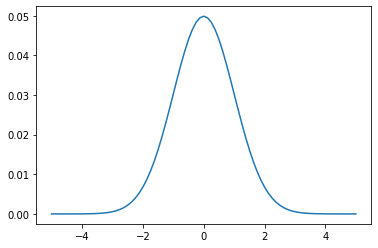

In [149]:
norm_distr = norm(loc=0, scale=1)
x = np.linspace(-5, 5, 81)
pdf = norm_distr.pdf(x)
pdf_normalized = pdf / pdf.sum()

plt.plot(x, pdf_normalized)
plt.show();

In [158]:
(1/2) * ((1/2) ** -2)

2.0

In [87]:
pdf_normalized[-1]

array([9.29199761e-07, 1.73962726e-05, 2.20372317e-04, 1.88891140e-03,
       1.09551886e-02, 4.29914254e-02, 1.14155686e-01, 2.05100619e-01,
       2.49338942e-01, 2.05100619e-01, 1.14155686e-01, 4.29914254e-02,
       1.09551886e-02, 1.88891140e-03, 2.20372317e-04, 1.73962726e-05,
       9.29199761e-07])

In [4]:
interface_labels = ["".join(pair) for pair in itertools.combinations_with_replacement(mineral_labels, 2)]
interface_labels

['QQ',
 'QP',
 'QK',
 'QB',
 'QO',
 'QA',
 'PP',
 'PK',
 'PB',
 'PO',
 'PA',
 'KK',
 'KB',
 'KO',
 'KA',
 'BB',
 'BO',
 'BA',
 'OO',
 'OA',
 'AA']

In [ ]:
interface_labels

## Mechanical weathering
____

In [ ]:
# Selection for breakage
# D = size of grain
# alpha_Qm = susceptibility to breakage normallized to monocrystalline quartz (Qm)
alpha_Qm = np.zeros((m, 1)) # CONSTANT
# delta_k = model time step
delta_k = int
# gamma = coefficient of time-step dependent strength of pcg # CONSTANT
gamma = float
# alpha = susceptibility to breakage
alpha = alpha_Qm + alpha_init * delta_k ** gamma
# z = abundance in the grain population
S = D * alpha * z
# probability of breakage ([m + 1] x d)
P = S / np.sum(S)

In [4]:
# Example values
mineral_constants = pd.DataFrame({"alpha_Qm": [1, 1.5, 1.2, 2, 3, 1.6]}, index=mineral_labels)
mineral_constants

,alpha_Qm
Q,1.0
P,1.5
K,1.2
B,2.0
O,3.0
A,1.6


### Inter-crystal breakage (of pcg)

In [27]:
# beta = (g x 1) susceptibility of mineral interface to breakage
interface_constants = pd.DataFrame({"beta_QQ": [(alpha[0] * alpha[1]) / 2 for alpha in itertools.combinations_with_replacement(mineral_constants["alpha_Qm"], 2)]}, index=interface_labels)
interface_constants

,beta_QQ
QQ,0.500
QP,0.750
QK,0.600
QB,1.000
QO,1.500
QA,0.800
PP,1.125
PK,0.900
PB,1.500
PO,2.250


### Intra-crystal breakage